In [3]:
import os
import torch
import pickle
import librosa
import pickle
import librosa.display
import IPython.display as ipd
import numpy as np
import soundfile as sf

from math import ceil
from model_vc import Generator
from synthesis import build_model
from synthesis import wavegen
from model_bl import D_VECTOR
from collections import OrderedDict


device = torch.device("cuda")
model = build_model().to(device)
checkpoint = torch.load("./pretrained/checkpoint_step001000000_ema.pth")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [17]:
def pad_seq(x, base=128):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

# metadata = pickle.load(open('metadata.pkl', "rb"))
emb370 = pickle.load(open('/data/hypark/VC/vcc/AUTO-VC2/autovc/mine/LibriSpeech/no_noise_train/p370_train.pkl', "rb"))
emb320 = pickle.load(open('/data/hypark/VC/vcc/AUTO-VC2/autovc/mine/LibriSpeech/no_noise_train/p320_train.pkl', "rb"))
emb370 = emb370[0][0]
emb320 = emb320[0][0]

In [103]:
C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda()
c_checkpoint = torch.load('./pretrained/3000000-BL.ckpt')
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val
C.load_state_dict(new_state_dict)
num_uttrs = 10
len_crop = 128

# Directory containing mel-spectrograms
embDir = '/data/cwbang/seminar/stargan-vc______/data/test_spmel/'

def embedding(root, source, target):
    dirName = os.path.join(embDir, source)
    embs = []
    _, _, fileList = next(os.walk(os.path.join(embDir, source)))
    for i in fileList:
        tmp = np.load(os.path.join(embDir, source, i))
        left = np.random.randint(0, tmp.shape[0]-len_crop)
        melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda()
        emb = C(melsp)
        embs.append(emb.detach().squeeze().cpu().numpy())     
    emb_source = np.mean(embs, axis=0)
    
    dirName = os.path.join(embDir, target)
    embs=[]
    _, _, fileList = next(os.walk(os.path.join(embDir, target)))
    for i in fileList:
        tmp = np.load(os.path.join(embDir, target, i))
        left = np.random.randint(0, tmp.shape[0]-len_crop)
        melsp = torch.from_numpy(tmp[np.newaxis, left:left+len_crop, :]).cuda()
        emb = C(melsp)
        embs.append(emb.detach().squeeze().cpu().numpy())     
    emb_target = np.mean(embs, axis=0)
    return emb_source, emb_target
                      
embSF3, embSF1 = embedding(embDir, 'SF3', 'SF1')

In [104]:
device = 'cuda:0'
G = Generator(252,256,512,32).eval().to(device)

g_checkpoint = torch.load('./model/g/classifier_last_252_.pt')
G.load_state_dict(g_checkpoint['model_state_dict'])

rootDir = '/data/hypark/VC/vcc/AUTO-VC2/autovc/mine/LibriSpeech/test_spec'
def conversion(source, target, source_emb, target_emb):
    save_path = f'./convert/{source}_{target}'
    emb_org = torch.from_numpy(source_emb[np.newaxis, :]).to(device)
    emb_trg = torch.from_numpy(target_emb[np.newaxis, :]).to(device)
    # _, _, fileList = next(os.walk(os.path.join(rootDir, source)))
    if source == 'p356':
        fileList = ['p356-0151..npy', 'p356-0148..npy', 'p356-0158..npy', 'p356-0160..npy', 'p356-0143..npy']
    elif source == 'p370':
        fileList = ['p370-0118..npy', 'p370-0116..npy', 'p370-0106..npy', 'p370-0105..npy', 'p370-0108..npy']
    for file in fileList:
        print(file)
        tmp = np.load(os.path.join(rootDir, source, file))
        x_org, len_pad = pad_seq(tmp)
        uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
        with torch.no_grad():
            _, x_identic_psnt, _, _ = G(uttr_org, emb_org, emb_trg)

        if len_pad == 0:
            uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
        else:
            uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
        librosa.display.specshow(uttr_trg.T) 
        os.makedirs(save_path, exist_ok=True)
        wav = wavegen(model, c=uttr_trg)
        sf.write(os.path.join(save_path, f'{file[:-4]}wav'), wav, samplerate=16000)
        # ipd.Audio(wav, rate=16000)

In [2]:
# tmp = np.load('/data/hypark/VC/vcc/AUTO-VC2/autovc/mine/LibriSpeech/test_spec/p356/p356-0110..npy')
# x_org, len_pad = pad_seq(tmp)
# uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)

In [1]:
# emb_org = torch.from_numpy(emb356[np.newaxis, :]).to(device)
# emb_trg = torch.from_numpy(embSF3[np.newaxis, :]).to(device)

In [120]:
with torch.no_grad():
    _, x_identic_psnt, _, _ = G(uttr_org, emb_org, emb_trg)
    uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()

    
if len_pad == 0:
    uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
else:
    uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()

wav = wavegen(model, c=uttr_trg)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123904/123904 [25:36<00:00, 80.64it/s]


p356-0151..npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 123904/123904 [22:03<00:00, 93.59it/s]


p356-0148..npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 118272/118272 [22:07<00:00, 89.09it/s]


p356-0158..npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124672/124672 [23:49<00:00, 87.20it/s]


p356-0160..npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108288/108288 [19:43<00:00, 91.50it/s]


p356-0143..npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 126720/126720 [19:16<00:00, 109.56it/s]


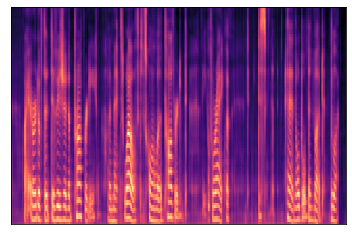

In [33]:
conversion('p356', 'SF3', emb356, embSF3)